<a href="https://colab.research.google.com/github/shubo7996/Comp_Neuro_NMA/blob/main/tutorials/W1D2_ModelFitting/student/W1D2_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 2: Linear regression with MLE

**Week 1, Day 2: Model Fitting**

**By Neuromatch Academy**

**Content creators**: Pierre-Étienne Fiquet, Anqi Wu, Alex Hyafil  with help from Byron Galbraith

**Content reviewers**: Lina Teichmann, Madineh Sarvestani, Patrick Mineault, Ella Batty, Michael Waskom

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial Objectives

*Estimated timing of tutorial: 30 minutes*

This is Tutorial 2 of a series on fitting models to data. We start with simple linear regression, using least squares optimization (Tutorial 1) and Maximum Likelihood Estimation (Tutorial 2). We will use bootstrapping to build confidence intervals around the inferred linear model parameters (Tutorial 3). We'll finish our exploration of regression models by generalizing to multiple linear regression and polynomial regression (Tutorial 4). We end by learning how to choose between these various models. We discuss the bias-variance trade-off (Tutorial 5) and Cross Validation for model selection (Tutorial 6).

In this tutorial, we will use a different approach to fit linear models that incorporates the random 'noise' in our data.
- Learn about probability distributions and probabilistic models
- Learn how to calculate the likelihood of our model parameters
- Learn how to implement the maximum likelihood estimator, to find the model parameter with the maximum likelihood



In [1]:
# @title Tutorial slides

# @markdown These are the slides for the videos in all tutorials today
from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/2mkq4/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

---
# Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
#@title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [4]:
# @title Plotting Functions
def plot_density_image(x, y, theta, sigma=1, ax=None):
  """ Plots probability distribution of y given x, theta, and sigma

  Args:

    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    theta (float): Slope parameter
    sigma (float): standard deviation of Gaussian noise

  """

  # plot the probability density of p(y|x,theta)
  if ax is None:
    fig, ax = plt.subplots()

  xmin, xmax = np.floor(np.min(x)), np.ceil(np.max(x))
  ymin, ymax = np.floor(np.min(y)), np.ceil(np.max(y))
  xx = np.linspace(xmin, xmax, 50)
  yy = np.linspace(ymin, ymax, 50)

  surface = np.zeros((len(yy), len(xx)))
  for i, x_i in enumerate(xx):
    surface[:, i] = stats.norm(theta * x_i, sigma).pdf(yy)

  ax.set(xlabel='x', ylabel='y')

  return ax.imshow(surface, origin='lower', aspect='auto', vmin=0, vmax=None,
            cmap=plt.get_cmap('Wistia'),
            extent=[xmin, xmax, ymin, ymax])

---
# Section 1: Maximum Likelihood Estimation (MLE)


In [5]:
# @title Video 1: Maximum Likelihood Estimation
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1Mg4y1i7WH", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="8mpNmzLKNfU", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

This video covers Maximum Likelihood Estimation (MLE) in the context of a 1D linear regression.


## Section 1.1: Gaussian noise


<details>
<summary> <font color='blue'>Click here for text recap of relevant part of video </font></summary>

In the previous tutorial we made the assumption that the data was drawn from a linear relationship with noise added, and found an effective approach for estimating model parameters based on minimizing the mean squared error.

In that case we treated the noise as simply a nuisance, but what if we factored it directly into our model?

Recall our linear model:

\begin{align}
y = \theta x + \epsilon.
\end{align}

The noise component $\epsilon$ is often modeled as a random variable drawn from a Gaussian distribution (also called the normal distribution).

The Gaussian distribution is described by its [probability density function](https://en.wikipedia.org/wiki/Probability_density_function) (pdf)
\begin{align}
\mathcal{N}(x; \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{1}{2\sigma^2}(x-\mu)^2}
\end{align}

and is dependent on two parameters: the mean $\mu$ and the variance $\sigma^2$. We often consider the noise signal to be Gaussian "white noise", with zero mean and unit variance:

\begin{align}
\epsilon \sim \mathcal{N}(0, 1).
\end{align}



### Interactive Demo 1.1: Gaussian Distribution Explorer

Use the explorer widget below to see how varying the $\mu$ and $\sigma$ parameters change the location and shape of the samples.


1.   What effect does varying $\mu$ have on the pdf?
2.   What effect does varying $\sigma$ have on the pdf?



In [6]:
# @markdown Make sure you execute this cell to enable the widget!

@widgets.interact(mu=widgets.FloatSlider(0.0, min=-2.0, max=2.0),
                  sigma=widgets.FloatSlider(1.0, min=0.5, max=2.0))
def plot_normal_dist(mu=0, sigma=1):

  # Generate pdf & samples from normal distribution with mu/sigma
  rv = stats.norm(mu, sigma)
  x = np.linspace(-5, 5, 100)
  y = rv.pdf(x)
  samples = rv.rvs(1000)

  # Plot
  fig, ax = plt.subplots()
  ax.hist(samples, 20, density=True, color='g', histtype='stepfilled', alpha=0.8,
          label='histogram')
  ax.plot(x, y, color='orange', linewidth=3, label='pdf')
  ax.vlines(mu, 0, rv.pdf(mu), color='y', linewidth=3, label='$\mu$')
  ax.vlines([mu-sigma, mu+sigma], 0, rv.pdf([mu-sigma, mu+sigma]), colors='red',
            color='b', linewidth=3, label='$\sigma$')
  ax.set(xlabel='x', ylabel='probability density', xlim=[-5, 5], ylim=[0, 1.0])
  ax.legend()

interactive(children=(FloatSlider(value=0.0, description='mu', max=2.0, min=-2.0), FloatSlider(value=1.0, desc…

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main//tutorials/W1D2_ModelFitting/solutions/W1D2_Tutorial2_Solution_5f94b40f.py)



## Section 1.2: Probabilistic Models

*Estimated timing to here from start of tutorial: 11 min*

Now that we have a model of our noise component $\epsilon$ as random variable, how do we incorporate this back into our original linear model from before? Consider again our simplified model $y = \theta x + \epsilon$ where the noise has zero mean and unit variance $\epsilon \sim \mathcal{N}(0, 1)$. We can now also treat $y$ as a random variable drawn from a Gaussian distribution where $\mu = \theta x$ and $\sigma^2 = 1$:

\begin{equation}
y \sim \mathcal{N}(\theta x, 1)
\end{equation}

which is to say that the probability of observing $y$ given $x$ and parameter $\theta$ is

\begin{equation}
p(y|x,\theta) = \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}(y-\theta x)^2}
\end{equation}


Note that in this and the following sections, we will focus on a single data point (a single pairing of $x$ and $y$). We have dropped the subscript $i$ just for simplicity (that is, we use $x$ for a single data point, instead of $x_i$). 

Now, let's revisit our original sample dataset where the true underlying model has $\theta = 1.2$.

In [7]:
# @markdown Execute this cell to generate some simulated data

# setting a fixed seed to our random number generator ensures we will always
# get the same psuedorandom number sequence

np.random.seed(121)
theta = 1.2
n_samples = 30
x = 10 * np.random.rand(n_samples) # sample from a uniform distribution over [0,10)
noise = np.random.randn(n_samples) # sample from a standard normal distribution
y = theta * x + noise

This time we can plot the density of $p(y|x,\theta=1.2)$ and see how $p(y)$ changes for different values of $x$.

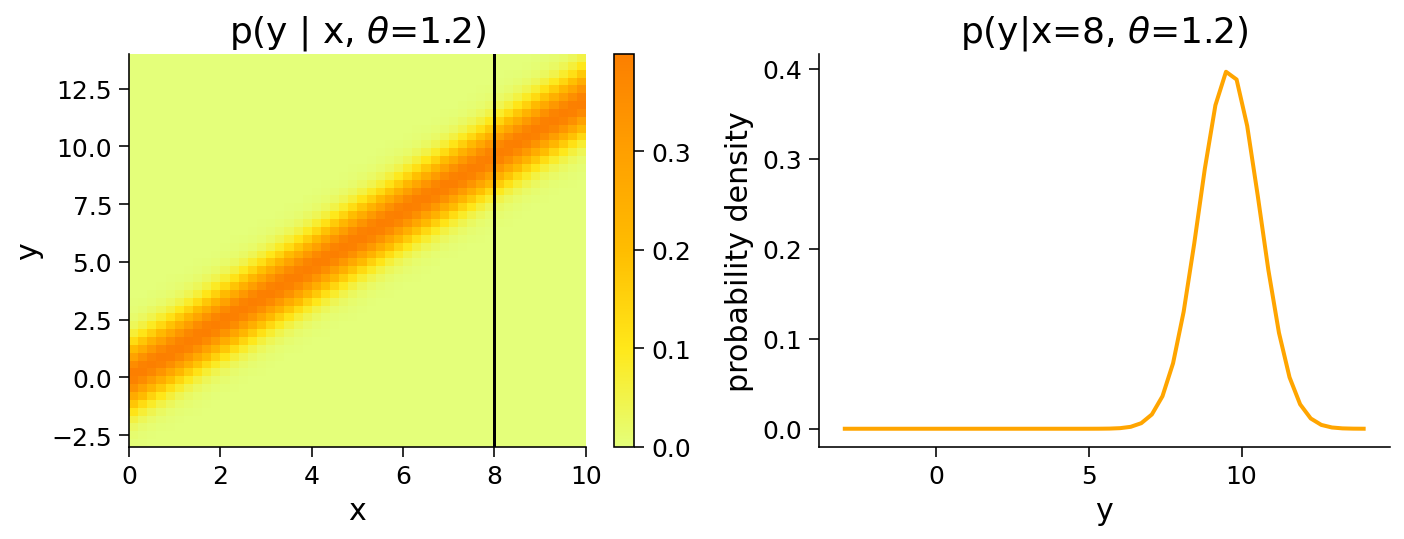

In [8]:
# @markdown Execute this cell to visualize p(y|x, theta=1.2)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

# Invokes helper function to generate density image plots from data and parameters
im = plot_density_image(x, y, 1.2, ax=ax1)
plt.colorbar(im, ax=ax1)
ax1.axvline(8, color='k')
ax1.set(title=r'p(y | x, $\theta$=1.2)')

# Plot pdf for given x
ylim = ax1.get_ylim()
yy = np.linspace(ylim[0], ylim[1], 50)
ax2.plot(yy, stats.norm(theta * 8, 1).pdf(yy), color='orange', linewidth=2)
ax2.set(
    title=r'p(y|x=8, $\theta$=1.2)',
    xlabel='y',
    ylabel='probability density');

## Section 1.3: Likelihood Estimation

*Estimated timing to here from start of tutorial: 15 min*

Now that we have our probabilistic model, we turn back to our original challenge of finding a good estimate for $\theta$ that fits our data. Given the inherent uncertainty when dealing in probabilities, we talk about the [likelihood](https://en.wikipedia.org/wiki/Likelihood_function) that some estimate $\hat{\theta}$ fits our data. The likelihood function $\mathcal{L}(\theta)$ is equal to the probability density function parameterized by that $\theta$:

\begin{equation}
\mathcal{L}(\theta|x,y) = p(y|x,\theta) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{1}{2\sigma^2}(y-\theta x)^2}
\end{equation}

### Coding Exercise 1.3: Likelihood Function

In this exercise you will implement the likelihood function $\mathcal{L}(\theta|x, y)$ for our linear model where $\sigma = 1$.

After implementing this function, we can produce probabilities that our estimate $\hat{\theta}$ generated the provided observations. We will try with one of the samples from our dataset.

TIP: Use `np.exp` and `np.sqrt` for the exponential and square root functions, respectively.

In [11]:
def likelihood(theta_hat, x, y):
  """The likelihood function for a linear model with noise sampled from a
    Gaussian distribution with zero mean and unit variance.

  Args:
    theta_hat (float): An estimate of the slope parameter.
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.

  Returns:
    ndarray: the likelihood values for the theta_hat estimate
  """
  sigma = 1
  ##############################################################################
  ## TODO for students: implement the likelihood function
  # Fill out function and remove
  #raise NotImplementedError("Student exercise: implement the likelihood function")
  ##############################################################################

  # Compute Gaussian likelihood
  pdf = 1/np.sqrt(2*3.14*(sigma**2))*np.exp(-1/2*(sigma**2)*(y-theta_hat*x)**2)

  return pdf


print(likelihood(1.0, x[1], y[1]))

0.11347320268373305


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main//tutorials/W1D2_ModelFitting/solutions/W1D2_Tutorial2_Solution_328a0c30.py)



We should see that $\mathcal{L}(\theta=1.0|x=2.1,y=3.7) \approx 0.11$. So far so good, but how does this tell us how this estimate is better than any others?

When dealing with a set of data points, as we are with our dataset, we are concerned with their joint probability -- the likelihood that all data points are explained by our parameterization. Since we have assumed that the noise affects each output independently, we can factorize the likelihood, and write:

\begin{equation}
\mathcal{L}(\theta|\mathbf{x}, \mathbf{y}) = \prod_{i=1}^N \mathcal{L}(\theta|x_i,y_i),
\end{equation}

where we have $N$ data points $\mathbf{x} = [x_1,...,x_N]$ and $\mathbf{y} = [y_1,...,y_N]$.

In practice, such a product can be numerically unstable. Indeed, multiplying small values together can lead to [arithmetic underflow](https://en.wikipedia.org/wiki/Arithmetic_underflow), the situation in which the digital representation of a floating point number reaches its limit. This problem can be circumvented by taking the logarithm of the likelihood because the logarithm transforms products into sums:

\begin{equation}
\log\mathcal{L}(\theta|\mathbf{x}, \mathbf{y}) = \sum_{i=1}^N \log\mathcal{L}(\theta|x_i,y_i)
\end{equation}

We can take the sum of the log of the output of our `likelihood` method applied to the full dataset to get a better idea of how different $\hat{\theta}$ compare. We can also plot the different distribution densities over our dataset and see how they line up qualitatively.

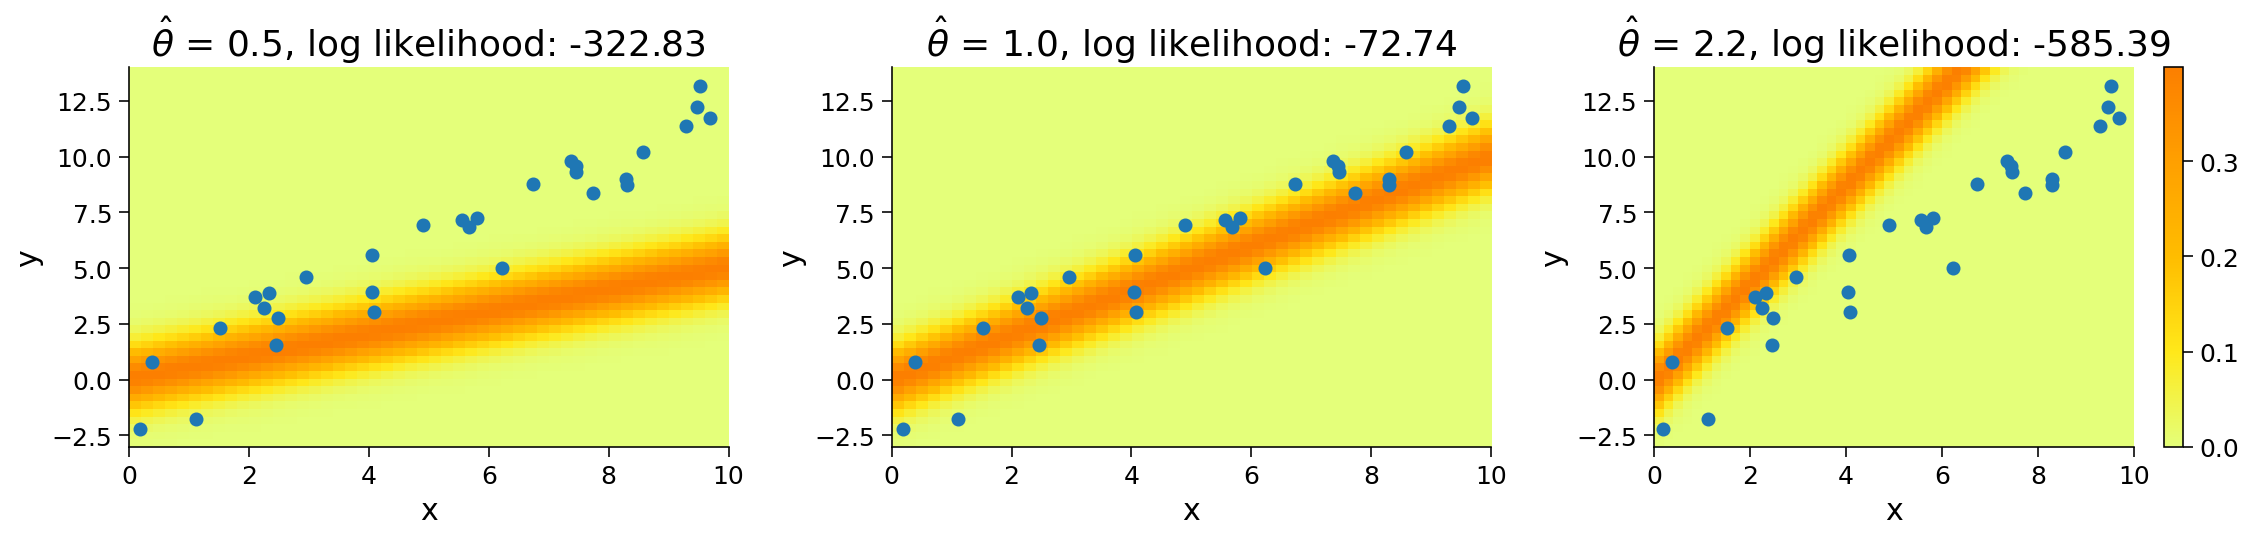

In [12]:
# @markdown Execute this cell to visualize different distribution densities
theta_hats = [0.5, 1.0, 2.2]
fig, axes = plt.subplots(ncols=3, figsize=(16, 4))
for theta_hat, ax in zip(theta_hats, axes):
  ll = np.sum(np.log(likelihood(theta_hat, x, y)))  # log likelihood
  im = plot_density_image(x, y, theta_hat, ax=ax)
  ax.scatter(x, y)
  ax.set(title=fr'$\hat{{\theta}}$ = {theta_hat}, log likelihood: {ll:.2f}')
plt.colorbar(im, ax=ax);

Using the log likelihood calculation, we see that $\mathcal{L}(\theta=1.0) > \mathcal{L}(\theta=0.5) > \mathcal{L}(\theta=2.2)$.

This is great: now we have a way to compare estimators based on likelihood. But like with the MSE approach, we want an analytic solution to find the best estimator. In this case, we want to find the estimator that maximizes the likelihood.


## Section 1.4: Finding the Maximum Likelihood Estimator

*Estimated timing to here from start of tutorial: 23 min*

<details>
<summary> <font color='blue'>Click here for text recap of relevant part of video </font></summary>

We want to find the parameter value $\hat\theta$ that makes our data set most likely:

\begin{align}
\hat{\theta}_{\textrm{MLE}} = \underset{\theta}{\operatorname{argmax}} \mathcal{L}(\theta|X,Y) 
\end{align}

We discussed how taking the logarithm of the likelihood helps with numerical stability, the good thing is that it does so without changing the parameter value that maximizes the likelihood. Indeed, the $\log()$ function is *monotonically increasing*, which means that it preserves the order of its inputs. So we have:

\begin{align}
\hat{\theta}_{\textrm{MLE}} = \underset{\theta}{\operatorname{argmax}} \sum_{i=1}^m \textrm{log} \mathcal{L}(\theta|x_i,y_i) 
\end{align}

Now substituting our specific likelihood function and taking its logarithm, we get:
\begin{align}
\hat{\theta}_{\textrm{MLE}} = \underset{\theta}{\operatorname{argmax}} [-\frac{N}{2} \operatorname{log} 2\pi\sigma^2 - \frac{1}{2\sigma^2}\sum_{i=1}^N (y_i-\theta x_i)^2].
\end{align}

Note that maximizing the log likelihood is the same as minimizing the negative log likelihood (in practice optimization routines are developed to solve minimization not maximization problems). Because of the convexity of this objective function, we can take the derivative of our negative log likelihhood, set it to 0, and solve - just like our solution to minimizing MSE.

\begin{align}
\frac{\partial\operatorname{log}\mathcal{L}(\theta|x,y)}{\partial\theta}=\frac{1}{\sigma^2}\sum_{i=1}^N(y_i-\theta x_i)x_i = 0
\end{align}

This looks remarkably like the equation we had to solve for the optimal MSE estimator, and, in fact, we arrive to the exact same solution!

\begin{align}
\hat{\theta}_{\textrm{MLE}} = \hat{\theta}_{\textrm{MSE}} = \frac{\sum_{i=1}^N x_i y_i}{\sum_{i=1}^N x_i^2}
\end{align}

In [13]:
# Compute theta_hat_MLE
theta_hat_mle = (x @ y) / (x @ x)

In [ ]:
#@title
#@markdown Execute this cell to visualize density with theta_hat_mle

# Plot the resulting distribution density
fig, ax = plt.subplots()
ll = np.sum(np.log(likelihood(theta_hat_mle, x, y))) # log likelihood
im = plot_density_image(x, y, theta_hat_mle, ax=ax)
plt.colorbar(im, ax=ax);
ax.scatter(x, y)
ax.set(title=fr'$\hat{{\theta}}$ = {theta_hat_mle:.2f}, log likelihood: {ll:.2f}');

---
# Summary

*Estimated timing of tutorial: 30 minutes*


Likelihood vs probability:

  - $\mathcal{L}(\theta|x, y) = p(y|x, \theta)$
  - $p(y|x, \theta) \rightarrow$ "probability of observing the response $y$ given parameter $\theta$ and input $x$"
  - $\mathcal{L}(\theta|x, y) \rightarrow$ "likelihood model that parameters $\theta$ produced response $y$ from input $x$"

Log-likelihood maximization:

  - We take the $\log$ of the likelihood function for computational convenience
  - The parameters $\theta$ that maximize $\log\mathcal{L}(\theta|x, y)$ are the model parameters that maximize the probability of observing the data.

**Key point**: the log-likelihood is a flexible cost function, and is often used to find model parameters that best fit the data.


---
# Notation

\begin{align}
x &\quad \text{input, independent variable}\\
y &\quad \text{response measurement, dependent variable}\\
\mathbf{x} &\quad \text{vector of input values}\\
\mathbf{y} &\quad \text{vector of measurements}\\
\epsilon &\quad \text{measurement error, noise contribution}\\
\epsilon \sim \mathcal{N}(\mu, \sigma^2) &\quad \text{random variable } \epsilon \text{ is distributed according to a Gaussian distribution, with mean } \mu \text{ and variance } \sigma^2\\
\mu &\quad \text{mean}\\
\sigma^2 &\quad \text{variance}\\
\sigma &\quad \text{standard deviation}\\
\theta &\quad \text{parameter}\\
\hat{\theta} &\quad \text{estimate of parameter}\\
\mathcal{L}(\theta|x, y) &\quad \text{likelihood of that parameter } \theta \text{ producing response } y \text{ from input } x \\ 
p(y|x, \theta) &\quad \text{probability of observing the response } y \text{ given input } x \text{ and parameter } \theta \\ 
\end{align}

---
# Bonus

We can also see $\mathrm{p}(\mathrm{y} | \mathrm{x}, \theta)$ as a function of $x$. This is the stimulus likelihood function, and it is useful in case we want to decode the input $x$ from observed responses $y$. This is what is relevant from the point of view of a neuron that does not have access to the outside world and tries to infer what's out there from the responses of other neurons!



